In [1]:
from google.colab import files
uploaded = files.upload()

Saving resampled_abnormal.npy to resampled_abnormal.npy
Saving resampled_normal.npy to resampled_normal.npy


In [2]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense

# 1. 데이터 로딩
X_normal = np.load('resampled_normal.npy')      # shape: (n, 100)
X_abnormal = np.load('resampled_abnormal.npy')  # shape: (m, 100)

y_normal = np.zeros(len(X_normal), dtype=int)
y_abnormal = np.ones(len(X_abnormal), dtype=int)

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

# 2. FFT + 정규화
X_fft = []
for sample in X:
    fft = np.abs(np.fft.fft(sample))[:50]  # 앞쪽 50개 주파수 성분만 사용
    norm_fft = MinMaxScaler().fit_transform(fft.reshape(-1,1)).flatten()
    X_fft.append(norm_fft)

X_fft = np.array(X_fft).reshape(-1, 50, 1)  # CNN 입력 형태로 변환

# 3. K-Fold 학습
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1

for train_idx, val_idx in kf.split(X_fft, y):
    print(f"\n📂 Fold {fold}")
    X_train, X_val = X_fft[train_idx], X_fft[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # 4. CNN 모델
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(50, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0)

    y_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_val, y_pred)
    print(f"✅ Fold {fold} Accuracy: {acc:.4f}")
    accuracies.append(acc)
    fold += 1

print(f"\n📊 평균 정확도 (FFT 기반 CNN): {np.mean(accuracies):.4f}")


📂 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 1 Accuracy: 0.9852

📂 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 2 Accuracy: 0.9800

📂 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 3 Accuracy: 0.9852

📂 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 4 Accuracy: 0.9800

📂 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 5 Accuracy: 0.9815

📊 평균 정확도 (FFT 기반 CNN): 0.9824


# 성능 비교 요약표

| 모델             | 평균 정확도 (5-Fold) |
| -------------- | --------------- |
| **CNN-only**   | 0.9842          |
| **CNN + LSTM** | 0.9863 ✅        |
| **FFT 기반 CNN** | 0.9824          |


# 분석 요약

| 항목    | CNN-only             | CNN+LSTM       | FFT+CNN                   |
| ----- | -------------------- | -------------- | ------------------------- |
| 입력 특징 | 원본 시계열 (time domain) | 원본 시계열 + 순서 정보 | 주파수 특성 (frequency domain) |
| 장점    | 빠르고 단순               | 순서 정보 반영       | noise에 강하고 리듬 분석 적합       |
| 정확도   | 98.42%               | **98.63%** ✅   | 98.24%                    |
| 결론    | 안정적                  | 가장 우수          | 나쁘지 않지만 시간 정보 미포함         |

# 3가지 모델 정리

3가지 모델을 동일한 조건에서 평가한 결과, CNN+LSTM 구조가 평균 98.63%로 가장 높은 정확도를 보였다. 이는 CNN이 추출한 시계열 특징을 LSTM이 시간 흐름 기반으로 종합함으로써 부정맥의 리듬 변화를 더 효과적으로 학습한 결과로 해석된다. 주파수 기반 FFT 모델 또한 98.24%의 우수한 성능을 보였으며, 이는 부정맥이 특정 주파수 영역에 나타나는 특성과 관련이 있다.

# 시각화

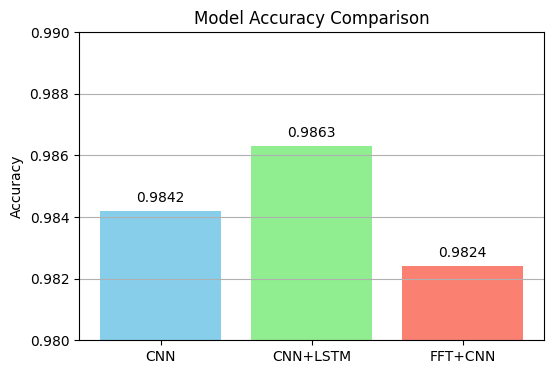

In [3]:
import matplotlib.pyplot as plt

models = ["CNN", "CNN+LSTM", "FFT+CNN"]
scores = [0.9842, 0.9863, 0.9824]

plt.figure(figsize=(6,4))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Model Accuracy Comparison")
plt.ylim(0.98, 0.99)
plt.ylabel("Accuracy")
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.0002, f"{yval:.4f}", ha='center', va='bottom')

plt.show()